In [1]:
from sympy import *
from sympy.abc import *
from sympy.galgebra.ga import *
import numpy as np
from numpy import linalg as LA
from __future__ import print_function
init_printing()

# Multi order stencil for the 2D/3D acoustic isotropic wave equation

In [2]:
# Choose dimension (2 or 3)
dim = 2
# Choose order
time_order = 6
space_order = 12

# half width for indexes, goes from -half to half
width_t = int(time_order/2)
width_h = int(space_order/2)

In [3]:
# Define functions and symbols
p=Function('p')
s,h = symbols('s h')
if dim==2:
    m=M(x,z)
    q=Q(x,z,t)
    d=D(x,z,t)
    solvep = p(x,z,t+width_t*s)
    solvepa = p(x,z,t-width_t*s)
else :
    m=M(x,y,z)
    q=Q(x,y,z,t)
    d=D(x,y,z,t)
    solvep = p(x,y,z,t+width_t*s)
    solvepa = p(x,y,z,t-width_t*s)

In [4]:
# Finite differences coefficients, not necessary here but good to have somewhere
def fd_coeff_1(order):
    if order==16:
        coeffs = [0.000010, -0.000178, 0.001554, -0.008702, 0.035354, -0.113131, 0.311111, -0.888889, 0.000000,
                  0.888889, -0.311111, 0.113131, -0.035354, 0.008702, -0.001554, 0.000178, -0.000010]
        
    if order==14:
        coeffs = [-0.000042, 0.000680, -0.005303, 0.026515, -0.097222, 0.291667, -0.875000, 0.000000,
                  0.875000, -0.291667, 0.097222, -0.026515, 0.005303, -0.000680, 0.000042]
        
    if order==12:
        coeffs = [ 0.0002, -0.0026, 0.0179, -0.0794, 0.2679, -0.8571, -0.0000, 0.8571, -0.2679, 0.0794, -0.0179, 0.0026, -0.0002]
        
    if order==10:
        coeffs =[-0.0008 , 0.0099, -0.0595, 0.2381, -0.8333, 0.0000, 0.8333, -0.2381, 0.0595, -0.0099, 0.0008]
        
    if order==8:
        coeffs = [1.0/280, -4.0/105, 1.0/5, -4.0/5, 0, 4.0/5, -1.0/5,4.0/105,-1.0/280]
    
    if space_order==6:
        coeffs = [-1.0/60, 3.0/20, -3.0/4, 0, 3.0/4, -3.0/20, 1.0/60]
    
    if space_order==4:
        coeffs = [1.0/12, -2.0/3, 0, 2.0/3, -1.0/12]
    
    if space_order==2:
        coeffs = [-0.5, 0, 0.5]
        
def fd_coeff_2(ordrer):
    if order==16:
        coeffs = [-0.000002, 0.000051, -0.000518, 0.003481, -0.017677, 0.075421, -0.311111, 1.777778, -3.054844,
                  1.777778, -0.311111, 0.075421, -0.017677, 0.003481, -0.000518, 0.000051, -0.000002]
        
    if order==14:
        coeffs = [0.000012, -0.000227, 0.002121, -0.013258, 0.064815, -0.291667, 1.750000, -3.023594, 
                  1.750000, -0.291667, 0.064815, -0.013258, 0.002121, -0.000227, 0.000012]
        
    if order==12:
        coeffs = [-0.000060, 0.001039, -0.008929, 0.052910, -0.267857, 1.714286, -2.982778,
                  1.714286, -0.267857, 0.052910, -0.008929, 0.001039, -0.000060]
        
    if order==10:
        coeffs = [0.000317, -0.004960, 0.039683, -0.238095, 1.666667, -2.927222,
                  1.666667, -0.238095, 0.039683, -0.004960, 0.000317]
        
    if order==8:
        coeffs = [-0.001786, 0.025397, -0.200000, 1.600000, -2.847222, 1.600000, -0.200000, 0.025397, -0.001786]
    
    if space_order==6:
        coeffs = [0.011111, -0.150000, 1.500000, -2.722222, 1.500000, -0.150000, 0.01111]
    
    if space_order==4:
        coeffs = [-0.083333, 1.333333, -2.500000, 1.333333, -0.08333]
    
    if space_order==2:
        coeffs = [1, -2, 1]

In [5]:
# Indexes for finite differences
indx = []
indy = []
indz = []
indt = []
for i in range(-width_h,width_h+1):
    indx.append(x + i * h)
    indy.append(y + i * h)
    indz.append(z + i* h)
    
for i in range(-width_t,width_t+1):
    indt.append(t + i * s)

In [6]:
# Finite differences
if dim==2:
    dtt=as_finite_diff(p(x,z,t).diff(t,t),indt)
    dxx=as_finite_diff(p(x,z,t).diff(x,x), indx) 
    dzz=as_finite_diff(p(x,z,t).diff(z,z), indz)
    dt=as_finite_diff(p(x,z,t).diff(t), indt)
    lap = dxx + dzz
else:
    dtt=as_finite_diff(p(x,y,z,t).diff(t,t),indt)
    dxx=as_finite_diff(p(x,y,z,t).diff(x,x), indx) 
    dyy=as_finite_diff(p(x,y,z,t).diff(y,y), indy) 
    dzz=as_finite_diff(p(x,y,z,t).diff(z,z), indz)
    dt=as_finite_diff(p(x,y,z,t).diff(t), indt)
    lap = dxx + dyy + dzz

In [7]:
# Argument list for lambdify
arglamb=[]
arglamba=[]
if dim==2:
    for i in range(-width_t,width_t):
        arglamb.append( p(x,z,indt[i+width_t]))
        arglamba.append( p(x,z,indt[i+width_t+1]))
        
    for i in range(-width_h,width_h+1):
        for j in range(-width_h,width_h+1):
            arglamb.append( p(indx[i+width_h],indz[j+width_h],t))
            arglamba.append( p(indx[i+width_h],indz[j+width_h],t))
else:
    for i in range(-width_t,width_t):
        arglamb.append( p(x,y,z,indt[i+width_t]))
        arglamba.append( p(x,y,z,indt[i+width_t+1]))
        
    for i in range(-width_h,width_h+1):
        for j in range(-width_h,width_h+1):
            for k in range(-width_h,width_h+1):
                arglamb.append( p(indx[i+width_h],indy[i+width_h],indz[j+width_h],t))
                arglamba.append( p(indx[i+width_h],indy[i+width_h],indz[j+width_h],t))
        
arglamb.extend((q , m, s, h, e))
arglamb=tuple(arglamb)
arglamba.extend((q , m, s, h, e))
arglamba=tuple(arglamba)

In [8]:
solvepa

# Forward and adjoint stencil 
2D-3D is automatic from the setup

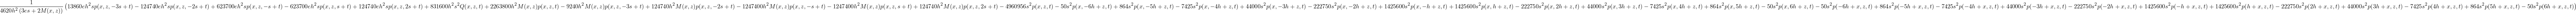

In [9]:
# Forward wave equation
wave_equation = m*dtt- lap- q  + e*dt
stencil = solve(wave_equation,solvep)[0]
ts=lambdify(arglamb,stencil,"numpy")
stencil

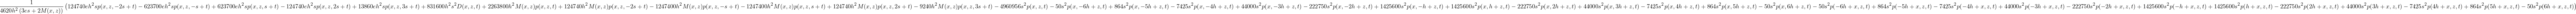

In [10]:
# Adjoint wave equation
wave_equationA = m*dtt- lap - d - e*dt
stencilA = solve(wave_equationA,solvepa)[0]
tsA=lambdify(arglamba,stencilA,"numpy")
stencilA